# Environmental Monitoring, Analysis, and Classification Using Machine Learning and Deep Learning Approaches to Discover Correlation Between LPG and Carbon Monoxide

### Details
The data was collected using three identical, custom-built, breadboard-based sensor arrays. Each array was linked to one or more Raspberry Pi devices. Each of the three Internet of Things devices was put in a different physical location with different ambient conditions.

| device            | environmental conditions                 |
|-------------------|------------------------------------------|
| 00:0f:00:70:91:0a | stable conditions, cooler and more humid |
| 1c:bf:ce:15:ec:4d | highly variable temperature and humidity |
| b8:27:eb:bf:9d:51 | stable conditions, warmer and dryer      |

On a regular basis, each IoT device gathered a total of seven distinct readings from the four sensors. Temperature, humidity, carbon monoxide (CO), liquefied petroleum gas (LPG), smoke, light, and motion are all measured by sensors. The data is from 07/12/2020 00:00:00 UTC to 07/19/2020 23:59:59 UTC. There are 405,184 rows of data in total.

C

### Columns
There are nine columns in the dataset, as follows.

| column   | description          | units      |
|----------|----------------------|------------|
| ts       | timestamp of event   | epoch      |
| device   | unique device name   | string     |
| co       | carbon monoxide      | l (%)    |
| humidity | humidity             | percentage |
| light    | light detected?      | boolean    |
| lpg      | liquid petroleum gas | l (%)    |
| motion   | motion detected?     | boolean    |
| smoke    | smoke                | l (%)    |
| temp     | temperature          | Fahrenheit |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sys

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import plot_roc_curve

In [2]:
df = pd.read_csv("iot_telemetry_data.csv")

In [3]:
df.head()

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,22.700000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,19.700001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,22.600000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,27.000000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,22.600000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ts        405184 non-null  float64
 1   device    405184 non-null  object 
 2   co        405184 non-null  float64
 3   humidity  405184 non-null  float64
 4   light     405184 non-null  bool   
 5   lpg       405184 non-null  float64
 6   motion    405184 non-null  bool   
 7   smoke     405184 non-null  float64
 8   temp      405184 non-null  float64
dtypes: bool(2), float64(6), object(1)
memory usage: 22.4+ MB


In [5]:
df.duplicated().sum()

13

In [6]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

ts          0
device      0
co          0
humidity    0
light       0
lpg         0
motion      0
smoke       0
temp        0
dtype: int64

    ts: This column represents the timestamp or time stamp of each data entry. It indicates the date and time at which the telemetry data was recorded. The timestamp allows you to track and analyze the data over time.

    device: The "device" column indicates the identifier or name of the specific device or sensor from which the telemetry data was collected. Each device may correspond to a different location or type of environmental monitoring.

    co: The "co" column represents the level of carbon monoxide in the environment. Carbon monoxide is a colorless and odorless gas that can be harmful at high concentrations. Monitoring CO levels is important for assessing air quality and potential health risks.

    humidity: This column denotes the relative humidity in the environment. Humidity refers to the amount of moisture or water vapor present in the air. Monitoring humidity levels is crucial for understanding moisture levels, predicting weather conditions, and assessing potential impacts on various ecosystems.

    light: The "light" column indicates the intensity or level of light in the environment. Light levels can vary based on factors such as time of day, weather conditions, and surrounding objects. Monitoring light levels can be useful for applications such as energy efficiency, plant growth, or security systems.

    lpg: This column represents the presence or concentration of liquefied petroleum gas (LPG) in the environment. LPG is a flammable gas commonly used for heating, cooking, and other purposes. Monitoring LPG levels is important for safety and to prevent potential hazards associated with gas leaks or accidents.

    motion: The "motion" column indicates the presence or detection of motion in the environment. It may be measured using motion sensors or other detection mechanisms. Monitoring motion can be useful for security systems, energy efficiency, or activity recognition in certain applications.

    smoke: This column represents the presence or concentration of smoke in the environment. Smoke can be an indicator of fire or other sources of air pollution. Monitoring smoke levels is critical for fire detection, air quality assessment, and early warning systems.

    temp: The "temp" column denotes the temperature in the environment. Temperature refers to the degree of hotness or coldness in the air. Monitoring temperature is essential for various applications, including weather forecasting, climate studies, and energy management.

In [9]:
# sort data
df = df.sort_values(by='ts', ascending=True)

In [10]:
# convert celsius to fahrenheit (°C to °F)
df['temp'] = (df['temp'] * 1.8) + 32

In [11]:
# preview data
df.head(5)

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,1.594512e+09,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,72.860000
1,1.594512e+09,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,67.460001
2,1.594512e+09,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,72.680000
3,1.594512e+09,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,80.600000
4,1.594512e+09,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,72.680000


In [12]:
# filter temp/humidity, by device, for outliers (>1% & <99%)
df = df.loc[df['temp'] >df.groupby('device').temp.transform(lambda x: x.quantile(.01))]
df = df.loc[df['temp'] < df.groupby('device').temp.transform(lambda x: x.quantile(.99))]

df = df.loc[df['humidity'] > df.groupby('device').humidity.transform(lambda x: x.quantile(.01))]
df = df.loc[df['humidity'] < df.groupby('device').humidity.transform(lambda x: x.quantile(.99))]

In [13]:
# group data by iot device
groups = df.groupby('device')

In [14]:
df['ts'] = pd.to_datetime(df['ts'], unit='s')

In [15]:
df.head(5)

,ts,device,co,humidity,light,lpg,motion,smoke,temp
0,2020-07-12 00:01:34.385974528,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,72.860000
1,2020-07-12 00:01:34.735567616,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,67.460001
2,2020-07-12 00:01:38.073572864,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,72.680000
3,2020-07-12 00:01:39.589145856,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,80.600000
4,2020-07-12 00:01:41.761234944,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,72.680000


In [16]:
print('DataFrame Stats')
print('-------------')
print('Record count: {:,}'.format(df['temp'].count()))
print('DataFrame size (MB): {:,.2f}'.format(sys.getsizeof(df)/1024/1024))
print('-------------')
print('Time range (min): {:%Y-%m-%d %H:%M:%S %Z}'.format(df.ts.iloc[1]))
print('Time range (max): {:%Y-%m-%d %H:%M:%S %Z}'.format(df.ts.iloc[-1]))
print('Temperature (min): {:.2f}'.format(df['temp'].min()))
print('Temperature (max): {:.2f}'.format(df['temp'].max()))
print('Humidity (min): {:.2f}{}'.format(df['humidity'].min(), '%'))
print('Humidity (max): {:.2f}{}'.format(df['humidity'].max(), '%'))
print('-------------')
print('Record count:\n{}'.format(groups.size()))

DataFrame Stats
-------------
Record count: 385,452
DataFrame size (MB): 48.52
-------------
Time range (min): 2020-07-12 00:01:34 
Time range (max): 2020-07-20 00:03:37 
Temperature (min): 65.66
Temperature (max): 86.36
Humidity (min): 46.60%
Humidity (max): 90.70%
-------------
Record count:
device
00:0f:00:70:91:0a    106187
1c:bf:ce:15:ec:4d    101051
b8:27:eb:bf:9d:51    178214
dtype: int64


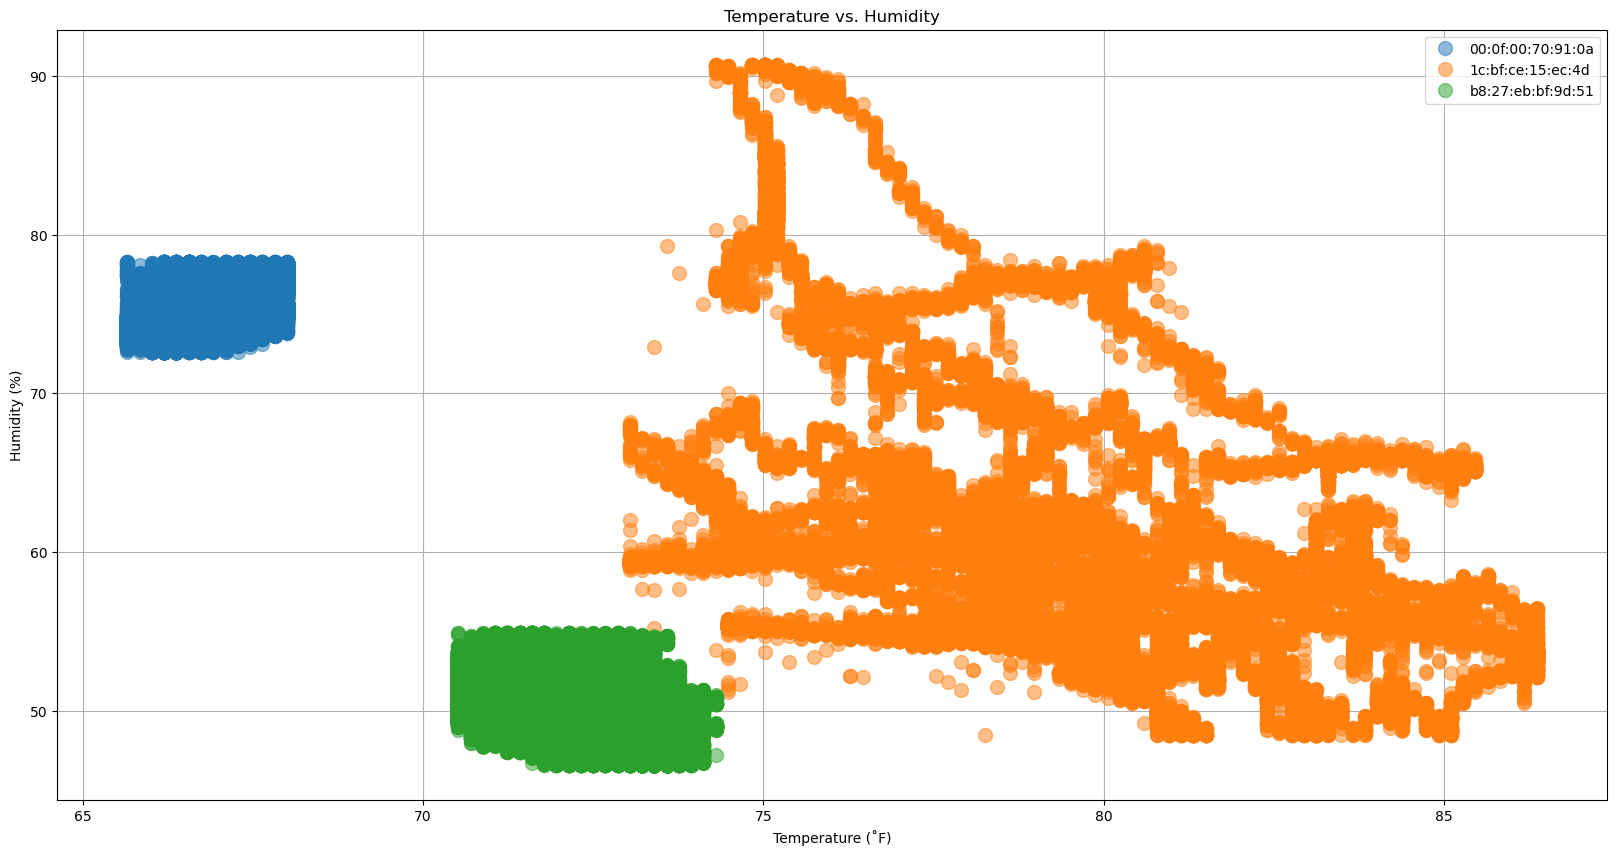

In [17]:
_, ax = plt.subplots(1, 1, figsize=(20, 10))
for device, group in groups:
    ax.plot(group.temp,
            group.humidity,
            marker='o',
            linestyle='',
            alpha=.5,
            ms=10,
            label=device)
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Temperature vs. Humidity')
plt.xlabel('Temperature (˚F)')
plt.ylabel('Humidity (%)')
plt.show()

### Temperature Graph (Moving Average)

    Smoothing data using the mean average of a 1 minute rolling window
    1 minutes == (20) data-points @ 3 second intervals

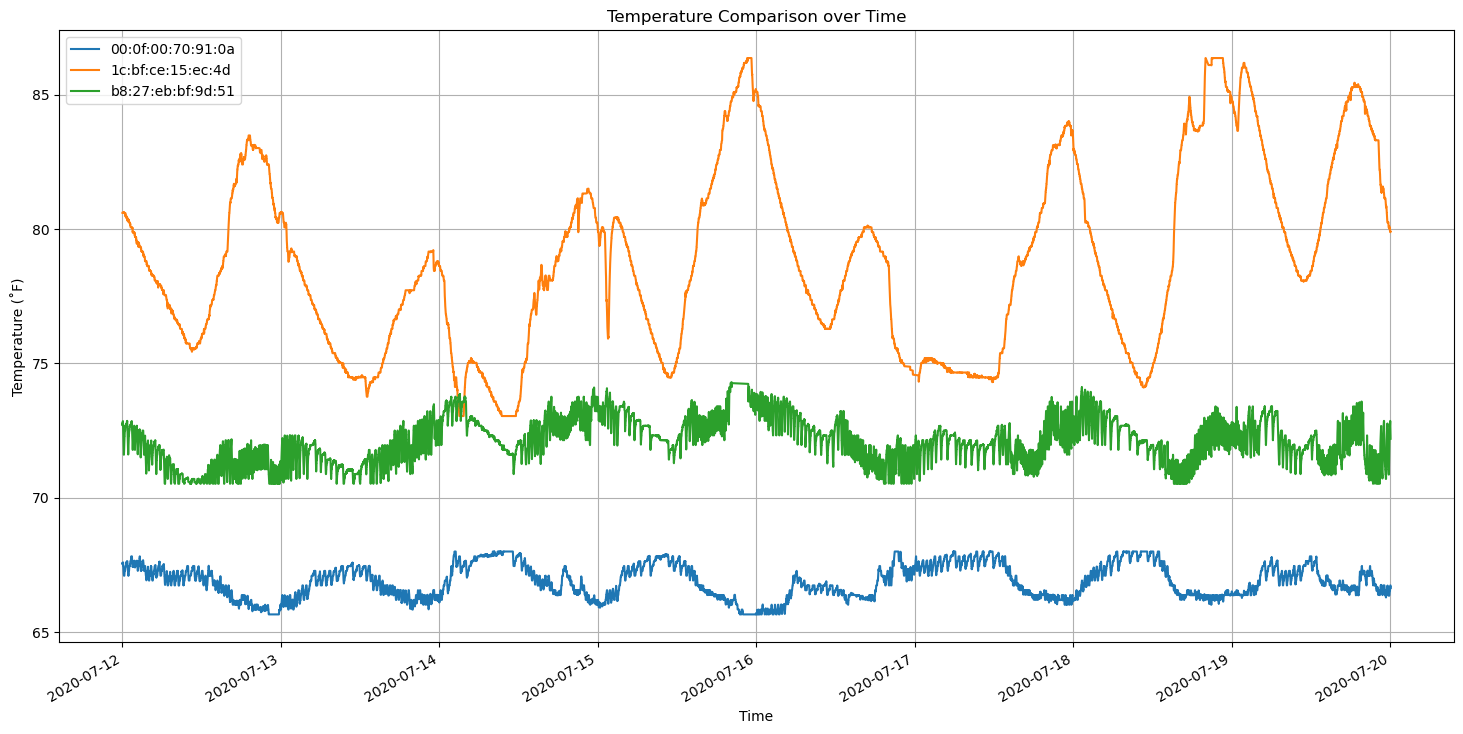

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
for device, group in groups:
    group_mean = group.temp.rolling(window=20).mean()
    ax.plot(group.ts, group_mean, label=device)
    
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Temperature Comparison over Time')
plt.ylabel('Temperature (˚F)')
plt.xlabel('Time')
plt.show()

### Humidity Graph (Moving Average)

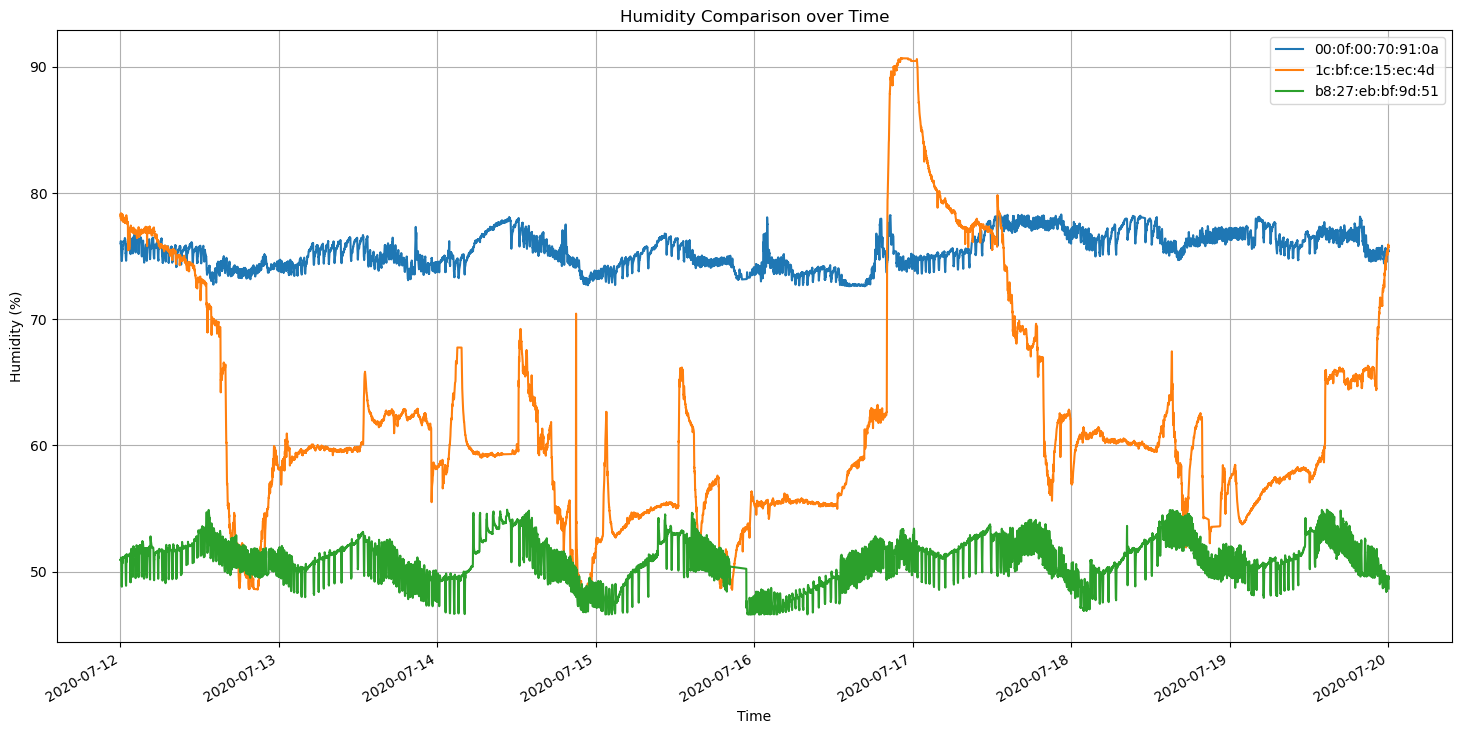

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
for device, group in groups:
    group.mean = group.humidity.rolling(window=20).mean()
    ax.plot(group.ts,group.mean,
            label=device)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Humidity Comparison over Time')
plt.ylabel('Humidity (%)')
plt.xlabel('Time')
plt.show()

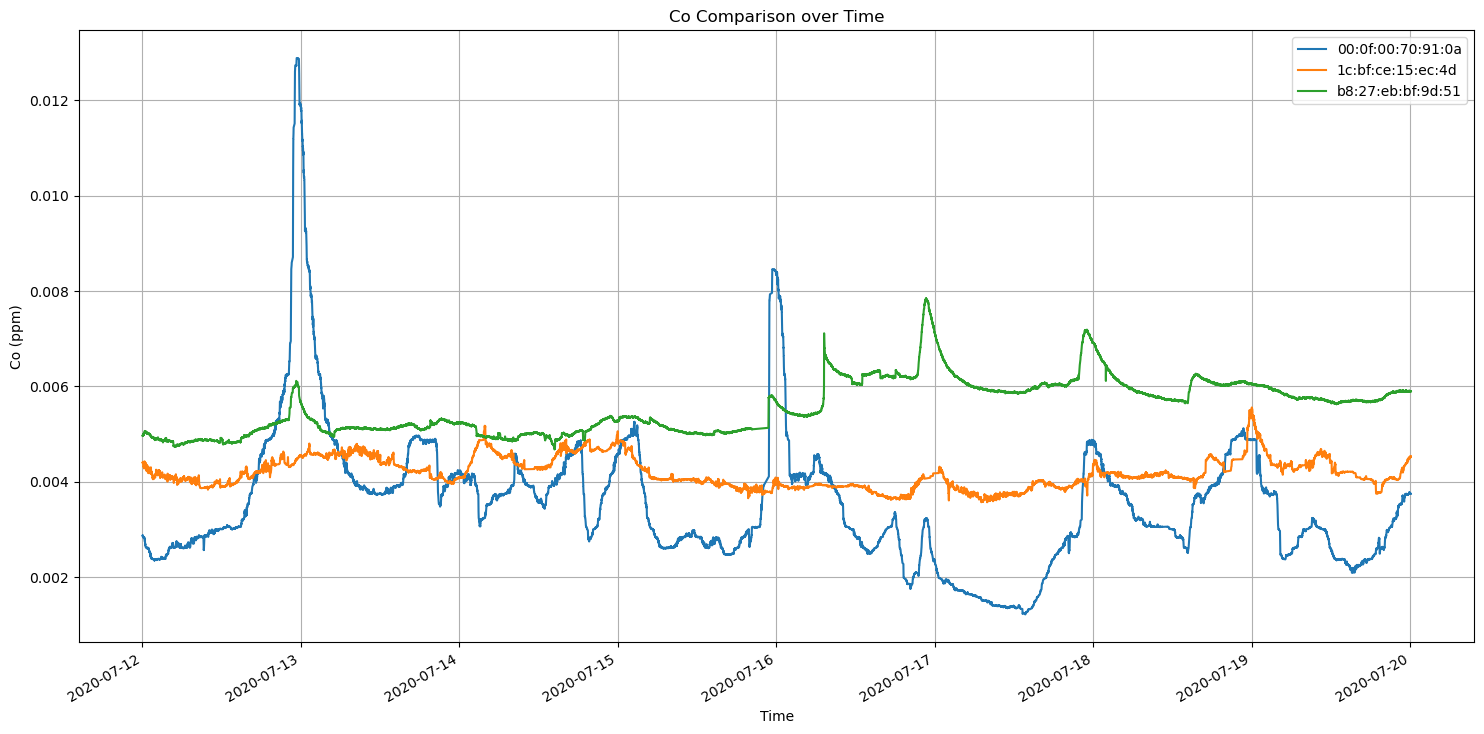

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
for device, group in groups:
    group.mean = group.co.rolling(window=20).mean()
    ax.plot(group.ts,group.mean,
            label=device)
fig.autofmt_xdate()
ax.grid()
ax.margins(0.05)
ax.legend()
plt.title('Co Comparison over Time')
plt.ylabel('Co (ppm)')
plt.xlabel('Time')
plt.show()

### Correlation between independent variables

C:\Users\Yamin Hossain\AppData\Local\Temp\ipykernel_19516\1970523766.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


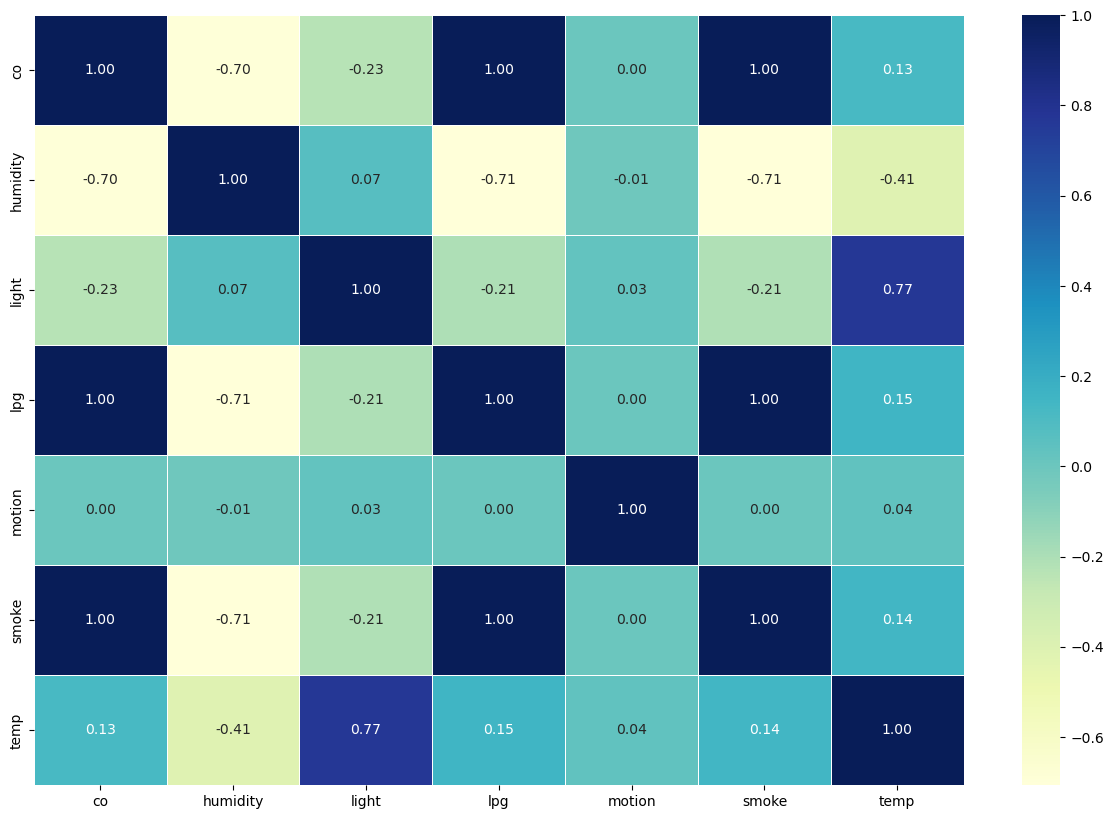

In [21]:
# Let's make it look a little prettier
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sn.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

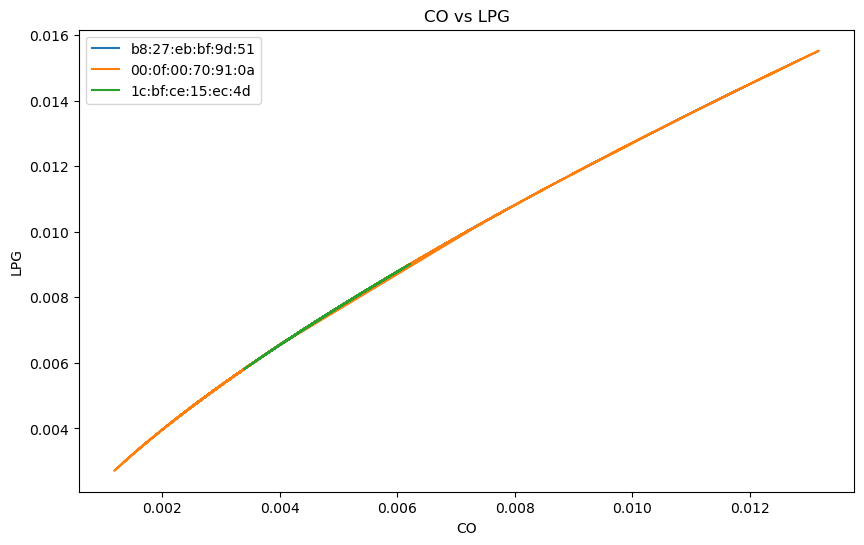

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over unique devices
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    ax.plot(device_data['co'], device_data['lpg'], label=device)

ax.set_xlabel('CO')
ax.set_ylabel('LPG')
ax.set_title('CO vs LPG')
ax.legend()
plt.show()

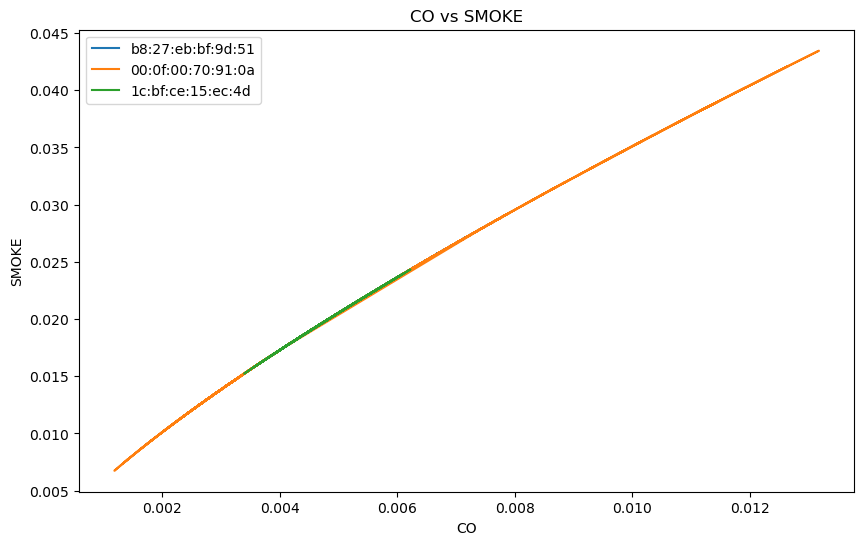

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over unique devices
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    ax.plot(device_data['co'], device_data['smoke'], label=device)

ax.set_xlabel('CO')
ax.set_ylabel('SMOKE')
ax.set_title('CO vs SMOKE')
ax.legend()
plt.show()

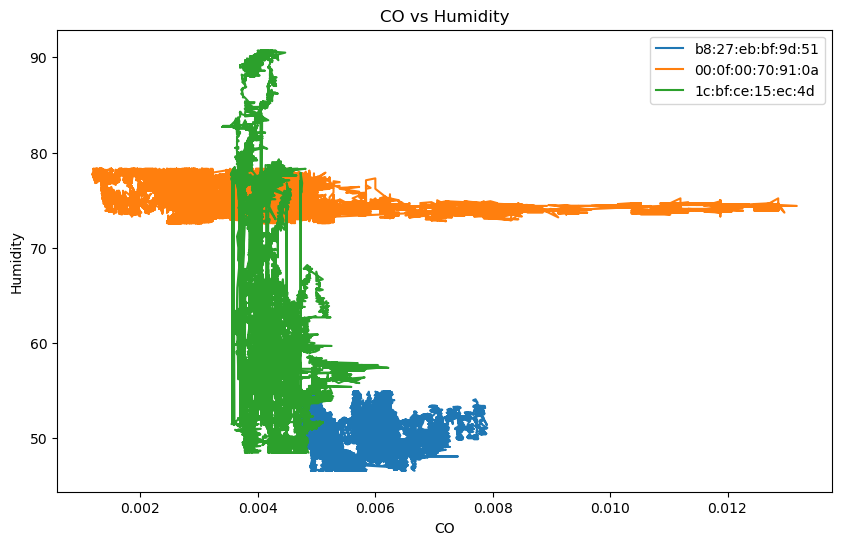

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over unique devices
for device in df['device'].unique():
    device_data = df[df['device'] == device]
    ax.plot(device_data['co'], device_data['humidity'], label=device)

ax.set_xlabel('CO')
ax.set_ylabel('Humidity')
ax.set_title('CO vs Humidity')
ax.legend()
plt.show()

In [25]:
df['date'] = df['ts'].dt.date.astype(str)
df['time'] = df['ts'].dt.strftime("%H:%M:%S %Z")

In [26]:
df.drop('ts', axis=1, inplace=True)

In [27]:
df.head()

,device,co,humidity,light,lpg,motion,smoke,temp,date,time
0,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,72.860000,2020-07-12,00:01:34
1,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,67.460001,2020-07-12,00:01:34
2,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,72.680000,2020-07-12,00:01:38
3,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,80.600000,2020-07-12,00:01:39
4,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,72.680000,2020-07-12,00:01:41


In [28]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
co,385452.0,0.004629,0.001216,0.001181,0.003919,0.004797,0.005412,0.013180
humidity,385452.0,60.521401,11.206908,46.600000,51.100000,54.900000,74.400002,90.699997
lpg,385452.0,0.007228,0.001413,0.002711,0.006456,0.007472,0.008154,0.015524
smoke,385452.0,0.019237,0.003995,0.006738,0.017024,0.019902,0.021849,0.043461
temp,385452.0,72.442076,4.755615,65.660001,67.819999,71.960000,74.480001,86.360001


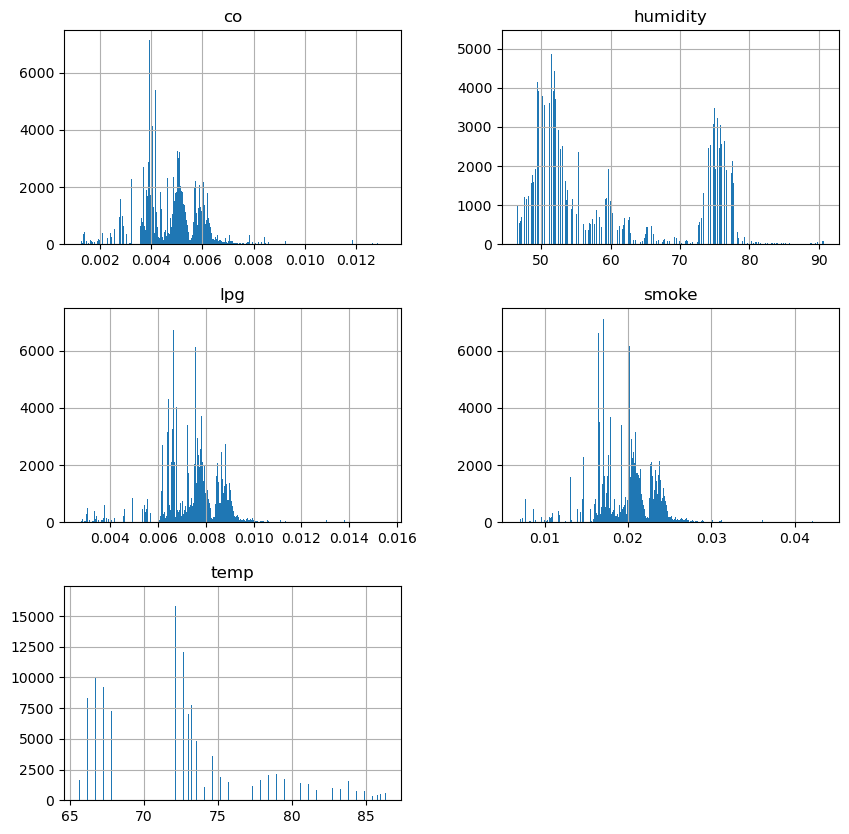

In [29]:
df.hist(bins=1000, figsize=(10, 10))
plt.show()

 I Take referance from this article https://www.epa.gov/indoor-air-quality-iaq/carbon-monoxides-impact-indoor-air-quality

And based this I got some info that

Average levels in homes without gas stoves vary from 0.5 to 5 parts per million (ppm). Levels near properly adjusted gas stoves are often 5 to 15 ppm and those near poorly adjusted stoves may be 30 ppm or higher.

[OSHA PEL] The current Occupational Safety and Health Administration (OSHA) permissible exposure limit (PEL) for carbon monoxide is 50 parts per million (ppm) parts of air (55 milligrams per cubic meter (mg/m(3))) as an 8-hour time-weighted average (TWA) concentration [29 CFR Table Z-1].

[NIOSH REL] The National Institute for Occupational Safety and Health (NIOSH) has established a recommended exposure limit (REL) for carbon monoxide of 35 ppm (40 mg/m(3)) as an 8-hour TWA and 200 ppm (229 mg/m(3)) as a ceiling [NIOSH 1992]. The NIOSH limit is based on the risk of cardiovascular effects.

[ACGIH TLV] The American Conference of Governmental Industrial Hygienists (ACGIH) has assigned carbon monoxide a threshold limit value (TLV) of 25 ppm (29 mg/m(3)) as a TWA for a normal 8-hour workday and a 40-hour workweek [ACGIH 1994, p. 15]. The ACGIH limit is based on the risk of elevated carboxyhemoglobin levels [ACGIH 1991, p. 229].

In [30]:
# Define the threshold
threshold = 0.005

# Create a new column 'label' based on CO levels
df['target'] = df['co'].apply(lambda x: 1 if x < threshold else 0)

df.head()

,device,co,humidity,light,lpg,motion,smoke,temp,date,time,target
0,b8:27:eb:bf:9d:51,0.004956,51.000000,False,0.007651,False,0.020411,72.860000,2020-07-12,00:01:34,1
1,00:0f:00:70:91:0a,0.002840,76.000000,False,0.005114,False,0.013275,67.460001,2020-07-12,00:01:34,1
2,b8:27:eb:bf:9d:51,0.004976,50.900000,False,0.007673,False,0.020475,72.680000,2020-07-12,00:01:38,1
3,1c:bf:ce:15:ec:4d,0.004403,76.800003,True,0.007023,False,0.018628,80.600000,2020-07-12,00:01:39,1
4,b8:27:eb:bf:9d:51,0.004967,50.900000,False,0.007664,False,0.020448,72.680000,2020-07-12,00:01:41,1


0 = more than 0.005 I am considering as a bad or gas in the room

1 = under 0.005 I am considering as a normal or good co environment

Here Target in co label

In [31]:
df['target'].value_counts()

1    227607
0    157845
Name: target, dtype: int64

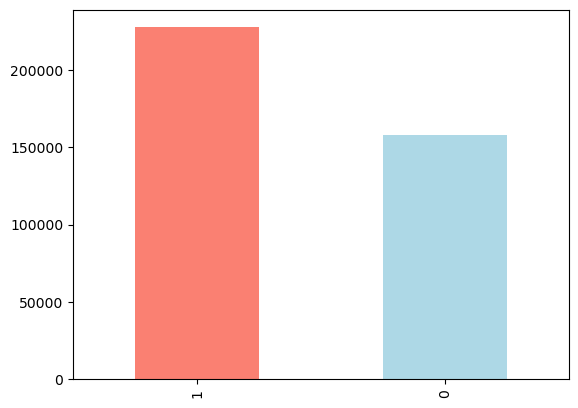

In [32]:
df.target.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [33]:
# Convert boolean values to integers
df['light'] = df['light'].astype(int)

In [34]:
# Convert boolean values to integers
df['motion'] = df['motion'].astype(int)

In [35]:
df['motion'].value_counts()

0    384997
1       455
Name: motion, dtype: int64

In [36]:
df['light'].value_counts()

0    278857
1    106595
Name: light, dtype: int64

In [37]:
df.head()

,device,co,humidity,light,lpg,motion,smoke,temp,date,time,target
0,b8:27:eb:bf:9d:51,0.004956,51.000000,0,0.007651,0,0.020411,72.860000,2020-07-12,00:01:34,1
1,00:0f:00:70:91:0a,0.002840,76.000000,0,0.005114,0,0.013275,67.460001,2020-07-12,00:01:34,1
2,b8:27:eb:bf:9d:51,0.004976,50.900000,0,0.007673,0,0.020475,72.680000,2020-07-12,00:01:38,1
3,1c:bf:ce:15:ec:4d,0.004403,76.800003,1,0.007023,0,0.018628,80.600000,2020-07-12,00:01:39,1
4,b8:27:eb:bf:9d:51,0.004967,50.900000,0,0.007664,0,0.020448,72.680000,2020-07-12,00:01:41,1


I am taking 10000 samples for further analysis with some machine learning techniques to train and test

In [38]:
sample_size = 10000
rs = df.sample(n=sample_size, random_state=42)

In [39]:
# Split data into X and Y
x = rs.drop(["target","date","time","co"], axis=1)
y = rs["target"]

In [40]:
x.head()

,device,humidity,light,lpg,motion,smoke,temp
156474,b8:27:eb:bf:9d:51,46.600000,0,0.008127,0,0.021772,72.680000
76203,b8:27:eb:bf:9d:51,52.700000,0,0.007803,0,0.020845,71.060000
247425,1c:bf:ce:15:ec:4d,89.800003,1,0.006432,0,0.016957,75.560001
329862,b8:27:eb:bf:9d:51,52.600000,0,0.008435,0,0.022655,71.780000
121836,00:0f:00:70:91:0a,77.699997,0,0.006456,0,0.017024,68.000000


In [41]:
from category_encoders import OneHotEncoder

# Initialize and fit the OneHotEncoder
encoder = OneHotEncoder(cols=['device'])
x = encoder.fit_transform(x)

In [42]:
x.head()

,device_1,device_2,device_3,humidity,light,lpg,motion,smoke,temp
156474,1,0,0,46.600000,0,0.008127,0,0.021772,72.680000
76203,1,0,0,52.700000,0,0.007803,0,0.020845,71.060000
247425,0,1,0,89.800003,1,0.006432,0,0.016957,75.560001
329862,1,0,0,52.600000,0,0.008435,0,0.022655,71.780000
121836,0,0,1,77.699997,0,0.006456,0,0.017024,68.000000


In [43]:
# Split data into train and test sets
np.random.seed(42)

# Split into train & test set
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.2)



### Logistic regression
### KNN

In [44]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
          "KNN": KNeighborsClassifier(),}

# Create a function to fit and score models
def fit_and_score(models, x_train, x_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(x_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(x_test, y_test)
    return model_scores

In [45]:
model_scores = fit_and_score(models=models,
                             x_train=x_train,
                             x_test=x_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

c:\Users\Yamin Hossain\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.921, 'KNN': 0.9375}

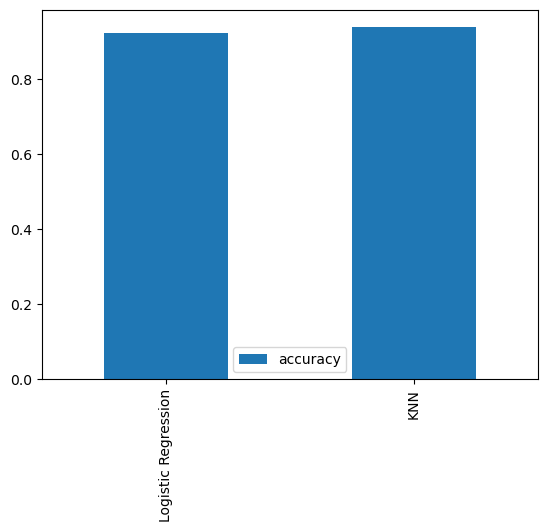

In [46]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar();

In [47]:
# Let's tune KNN

train_scores = []
test_scores = []

# Create a list of differnt values for n_neighbors
neighbors = range(1, 21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    # Fit the algorithm
    knn.fit(x_train, y_train)
    
    # Update the training scores list
    train_scores.append(knn.score(x_train, y_train))
    
    # Update the test scores list
    test_scores.append(knn.score(x_test, y_test))

In [48]:
train_scores

[1.0,
 0.973,
 0.967875,
 0.954,
 0.95,
 0.945,
 0.945625,
 0.942375,
 0.942125,
 0.9395,
 0.937875,
 0.93525,
 0.93425,
 0.93275,
 0.9335,
 0.93025,
 0.92925,
 0.928,
 0.927,
 0.928]

In [49]:
test_scores

[0.95,
 0.942,
 0.938,
 0.9355,
 0.9375,
 0.9365,
 0.9385,
 0.9375,
 0.9395,
 0.9395,
 0.942,
 0.943,
 0.942,
 0.9395,
 0.9385,
 0.9305,
 0.934,
 0.932,
 0.9325,
 0.934]

Maximum KNN score on the test data: 95.00%


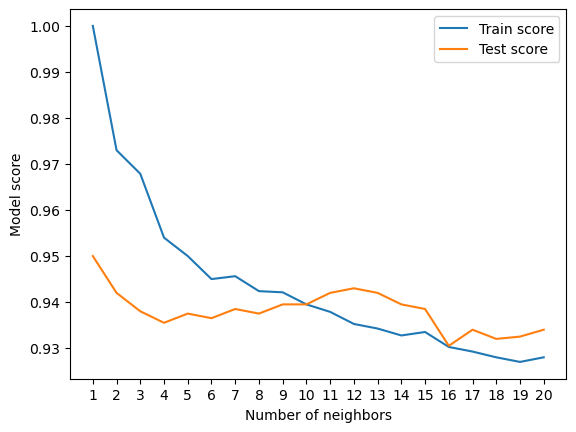

In [50]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

### RandomizedSearchCV

In [51]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

In [52]:
# Tune LogisticRegression

np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for LogisticRegression
rs_log_reg.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [53]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 10000.0}

In [54]:
rs_log_reg.score(x_test, y_test)

0.927

### Hyperparamter Tuning with GridSearchCV

In [55]:
# Different hyperparameters for our LogisticRegression model
log_reg_grid = {"C": np.logspace(-4, 4, 30),
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(x_train, y_train);

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [56]:
# Check the best hyperparmaters
gs_log_reg.best_params_

{'C': 10000.0, 'solver': 'liblinear'}

In [57]:
# Evaluate the grid search LogisticRegression model
gs_log_reg.score(x_test, y_test)

0.927

### KNN
### Logistic Regression
### ANN
### naive_bayes/GaussianNB
### LinearDiscreteRegression
### Support Vector Machines

In [58]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

def calculate_classification_metrics(models, x_test, y_test):
    metrics = {}
    
    for model_name, model in models.items():
        model.fit(x_train, y_train)  # Fit the model on the training data
        predictions = model.predict(x_test)
        
        classification_metrics = classification_report(y_test, predictions)
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, average='weighted')
        recall = recall_score(y_test, predictions, average='weighted')
        f_measure = f1_score(y_test, predictions, average='weighted')
        variance = np.var(predictions)
        std_deviation = np.std(predictions)
        mean = np.mean(predictions)
        mean_error = np.mean(np.abs(predictions - y_test))
        
        metrics[model_name] = {
            'Classification Metrics': classification_metrics,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F-measure': f_measure,
            'Variance': variance,
            'Standard Deviation': std_deviation,
            'Mean': mean,
            'Mean Error': mean_error
        }
    
    return metrics

# Dictionary of model names and models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=1),
    'LogisticRegression': LogisticRegression(),
    'ANN': MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000),
    'naive_bayes/GaussianNB': GaussianNB(),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'Support Vector Machine': SVC(),
    'CatBoostClassifier' : CatBoostClassifier()
}

# Calculate classification metrics
classification_metrics = calculate_classification_metrics(models, x_test, y_test)

# Print the metrics for each model
for model_name, metrics in classification_metrics.items():
    print("Model:", model_name)
    print("Classification Metrics:")
    print(metrics['Classification Metrics'])
    print("Accuracy:", metrics['Accuracy'])
    print("Precision:", metrics['Precision'])
    print("Recall:", metrics['Recall'])
    print("F-measure:", metrics['F-measure'])
    print("Variance:", metrics['Variance'])
    print("Standard Deviation:", metrics['Standard Deviation'])
    print("Mean:", metrics['Mean'])
    print("Mean Error:", metrics['Mean Error'])
    print()

c:\Users\Yamin Hossain\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Learning rate set to 0.025035
0:	learn: 0.6088168	total: 137ms	remaining: 2m 16s
1:	learn: 0.5357164	total: 140ms	remaining: 1m 9s
2:	learn: 0.4731088	total: 143ms	remaining: 47.4s
3:	learn: 0.4140674	total: 144ms	remaining: 35.9s
4:	learn: 0.3595220	total: 147ms	remaining: 29.2s
5:	learn: 0.3162955	total: 149ms	remaining: 24.8s
6:	learn: 0.2741171	total: 152ms	remaining: 21.6s
7:	learn: 0.2427395	total: 155ms	remaining: 19.2s
8:	learn: 0.2137879	total: 157ms	remaining: 17.3s
9:	learn: 0.1881087	total: 160ms	remaining: 15.8s
10:	learn: 0.1687346	total: 162ms	remaining: 14.6s
11:	learn: 0.1469853	total: 165ms	remaining: 13.6s
12:	learn: 0.1304130	total: 168ms	remaining: 12.8s
13:	learn: 0.1161510	total: 170ms	remaining: 12s
14:	learn: 0.1060650	total: 173ms	remaining: 11.4s
15:	learn: 0.0948015	total: 176ms	remaining: 10.8s
16:	learn: 0.0841356	total: 179ms	remaining: 10.3s
17:	learn: 0.0754921	total: 181ms	remaining: 9.88s
18:	learn: 0.0672845	total: 183ms	remaining: 9.47s
19:	learn: 0

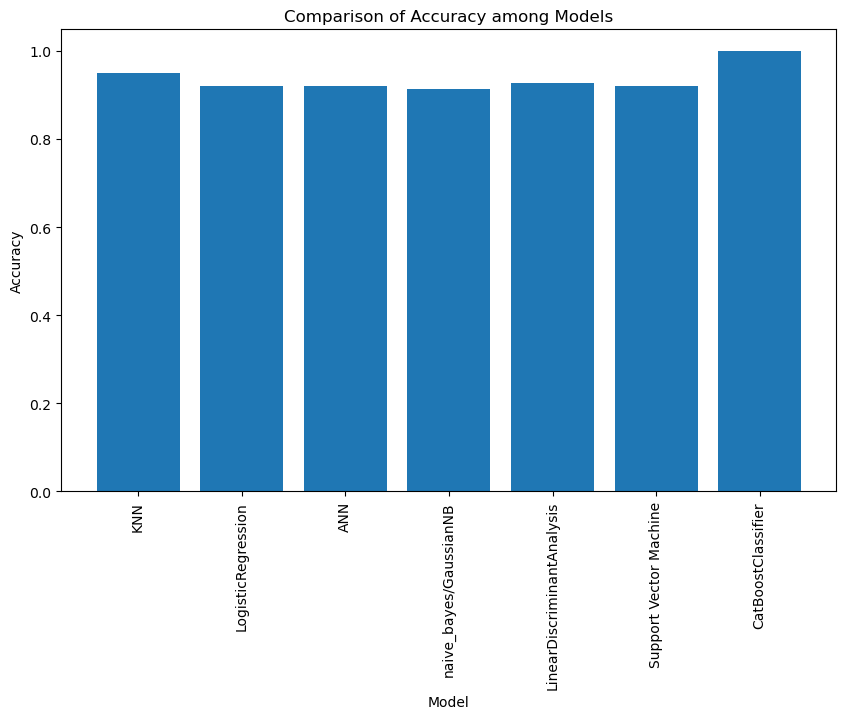

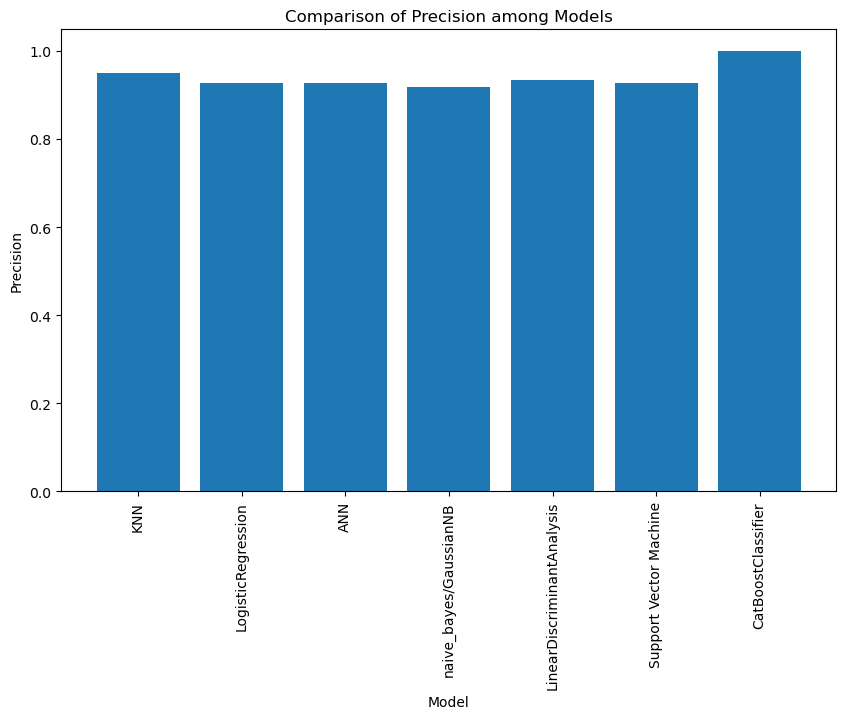

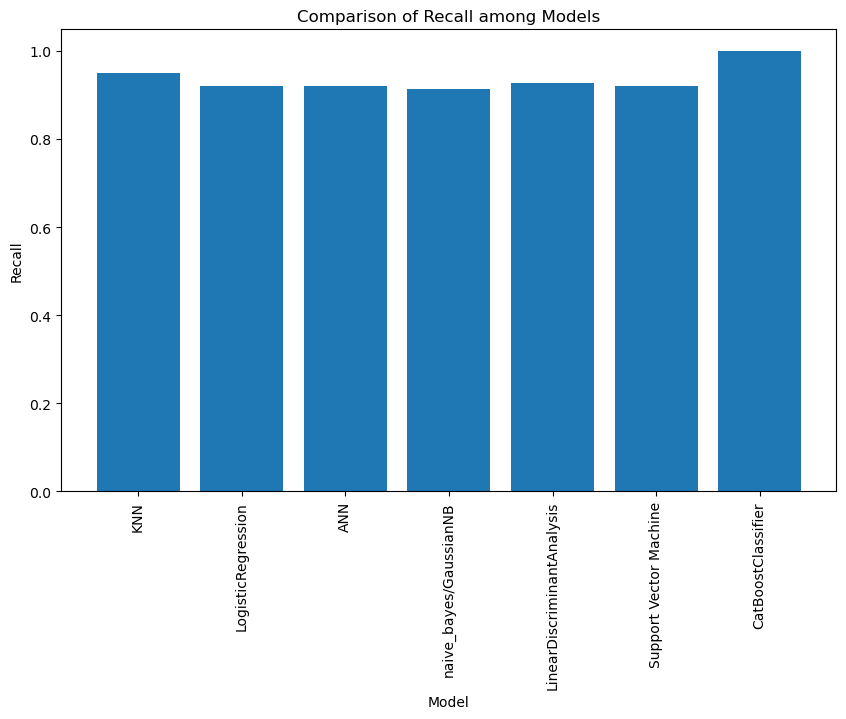

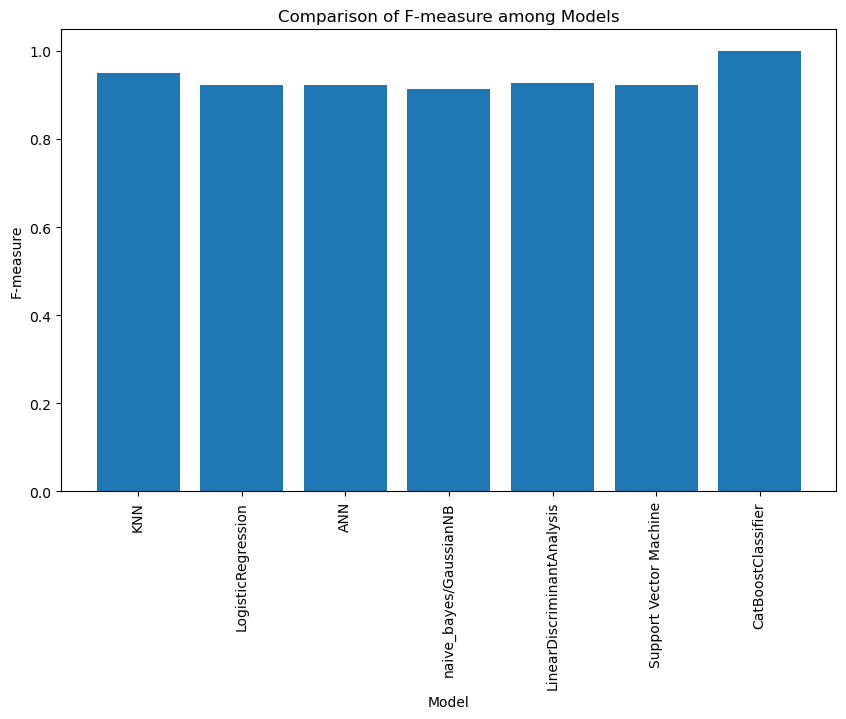

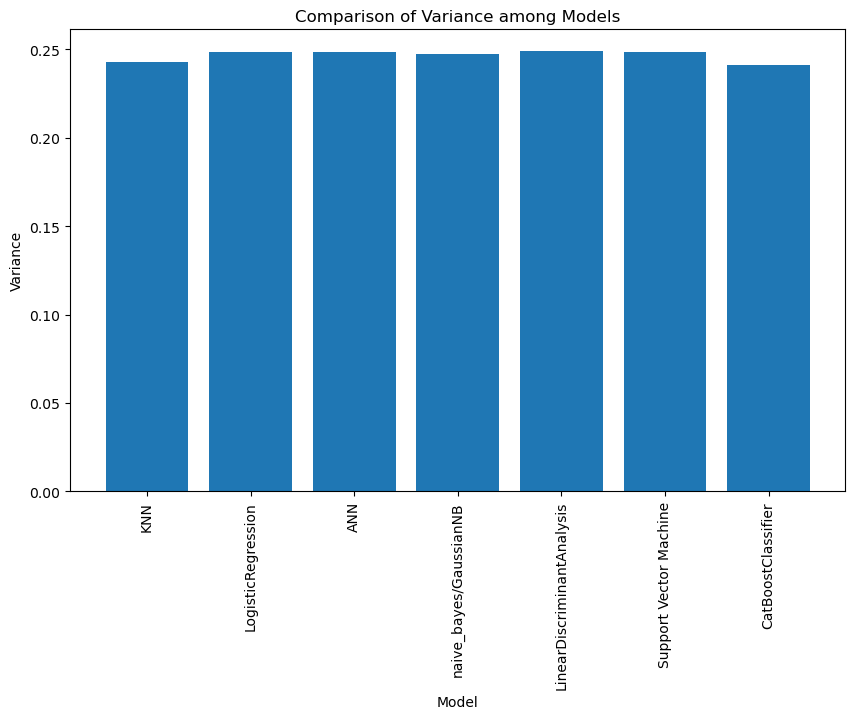

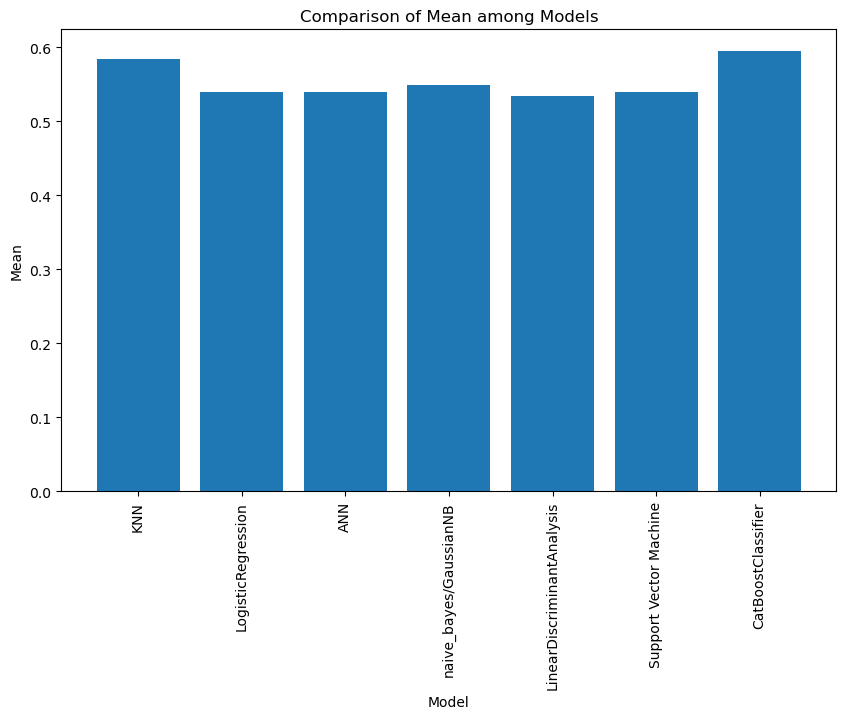

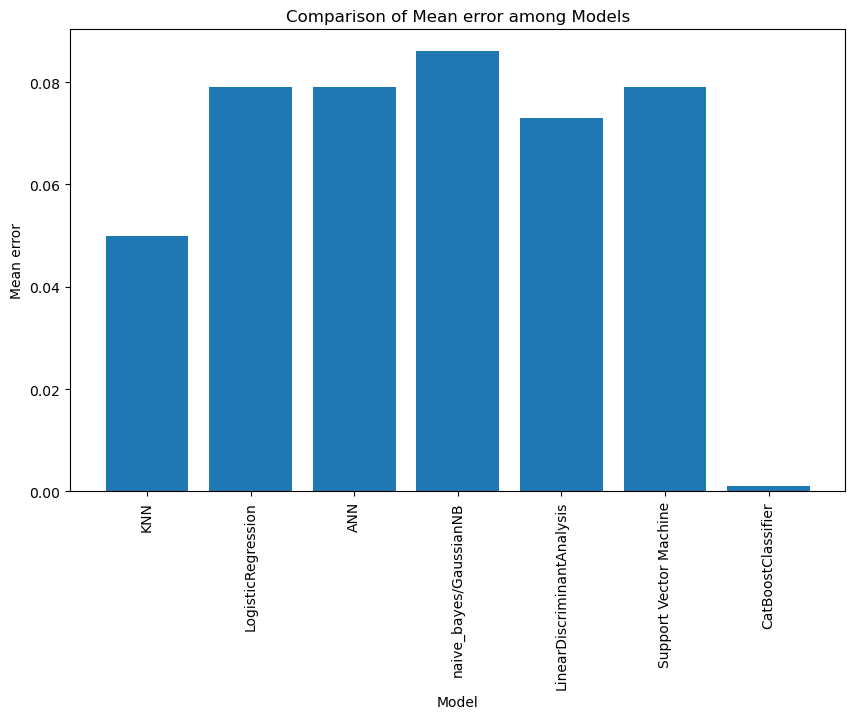

In [59]:
import matplotlib.pyplot as plt

# Initialize lists to store the metric values
model_names = []
accuracy_values = []
precision_values = []
Recall = []
F_measure = []
Variances = []
# Standard_Deviation = []
Mean = []
Mean_error = []

# Collect metric values for each model
for model_name, metrics in classification_metrics.items():
    model_names.append(model_name)
    accuracy_values.append(metrics['Accuracy'])
    precision_values.append(metrics['Precision'])
    Recall.append(metrics['Recall'])
    F_measure.append(metrics['F-measure'])
    Variances.append(metrics['Variance'])
    # Standard_Deviation(metrics['Standard Deviation'])
    Mean.append(metrics['Mean'])
    Mean_error.append(metrics['Mean Error'])
    

# Plot the comparison of accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy among Models')
plt.xticks(rotation=90)
plt.show()

# Plot the comparison of precision
plt.figure(figsize=(10, 6))
plt.bar(model_names, precision_values)
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Comparison of Precision among Models')
plt.xticks(rotation=90)
plt.show()

# Plot the comparison of recall
plt.figure(figsize=(10, 6))
plt.bar(model_names, Recall)
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Comparison of Recall among Models')
plt.xticks(rotation=90)
plt.show()

# Plot the comparison of F-measure
plt.figure(figsize=(10, 6))
plt.bar(model_names, F_measure)
plt.xlabel('Model')
plt.ylabel('F-measure')
plt.title('Comparison of F-measure among Models')
plt.xticks(rotation=90)
plt.show()

# Plot the comparison of variance   
plt.figure(figsize=(10, 6))
plt.bar(model_names, Variances)
plt.xlabel('Model')
plt.ylabel('Variance')
plt.title('Comparison of Variance among Models')
plt.xticks(rotation=90)
plt.show()

# plt.figure(figsize=(10, 6))
# plt.bar(model_names, Standard_Deviation)
# plt.xlabel('Model')
# plt.ylabel('Standard Deviation')
# plt.title('Comparison of Standard Deviation among Models')
# plt.xticks(rotation=90)
# plt.show()

# Plot the comparison of variance   
plt.figure(figsize=(10, 6))
plt.bar(model_names, Mean)
plt.xlabel('Model')
plt.ylabel('Mean')
plt.title('Comparison of Mean among Models')
plt.xticks(rotation=90)
plt.show()


plt.figure(figsize=(10, 6))
plt.bar(model_names, Mean_error)
plt.xlabel('Model')
plt.ylabel('Mean error')
plt.title('Comparison of Mean error among Models')
plt.xticks(rotation=90)
plt.show()

### Neural Network

In [62]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Convert target variable to binary form
y_train_binary = (y_train >= 0.5).astype(int)
y_test_binary = (y_test >= 0.5).astype(int)

# Create the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 32
model.fit(x_train, y_train_binary, epochs=epochs, batch_size=batch_size)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test_binary)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

# Make predictions on the test data
predictions = model.predict(x_test)
predicted_classes = np.round(predictions)

# Flatten the arrays
y_test_binary_flat = np.ravel(y_test_binary)
predicted_classes_flat = np.ravel(predicted_classes)

# For classification models
classification_metrics = classification_report(y_test_binary_flat, predicted_classes_flat)
print("Classification Metrics:")
print(classification_metrics)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary_flat, predicted_classes_flat)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_test_binary_flat, predicted_classes_flat, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_test_binary_flat, predicted_classes_flat, average='weighted')
print("Recall:", recall)

# Calculate F-measure
f_measure = f1_score(y_test_binary_flat, predicted_classes_flat, average='weighted')
print("F-measure:", f_measure)

# Calculate variance
variance = np.var(predictions)
print("Variance:", variance)

# Calculate standard deviation
std_deviation = np.std(predictions)
print("Standard Deviation:", std_deviation)

# Calculate mean
mean = np.mean(predictions)
print("Mean:", mean)

# Calculate mean error
mean_error = np.mean(np.abs(predictions - y_test_binary_flat))
print("Mean Error:", mean_error)

Epoch 1/10
250/250 [==============================] - 1s 785us/step - loss: 0.4108 - accuracy: 0.8339
Epoch 2/10
250/250 [==============================] - 0s 752us/step - loss: 0.2925 - accuracy: 0.9064
Epoch 3/10
250/250 [==============================] - 0s 792us/step - loss: 0.3001 - accuracy: 0.9028
Epoch 4/10
250/250 [==============================] - 0s 758us/step - loss: 0.2834 - accuracy: 0.9060
Epoch 5/10
250/250 [==============================] - 0s 753us/step - loss: 0.2829 - accuracy: 0.9061
Epoch 6/10
250/250 [==============================] - 0s 775us/step - loss: 0.2812 - accuracy: 0.9068
Epoch 7/10
250/250 [==============================] - 0s 758us/step - loss: 0.2842 - accuracy: 0.9043
Epoch 8/10
250/250 [==============================] - 0s 806us/step - loss: 0.2785 - accuracy: 0.9074
Epoch 9/10
250/250 [==============================] - 0s 774us/step - loss: 0.2762 - accuracy: 0.9068
Epoch 10/10
63/63 [==============================] - 0s 750us/step - loss: 0.2395 